<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/RASCUNHO_de_Analise_SIMPOSIO_OF_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # BIBLIOTECAS

In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install open-ephys-python-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.7/380.7 kB 24.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.5-py3-none-any.whl size=38855 sha256=9ac2b3cdb4b6ff5a1da2e0280ded1ce9e566c9355dd8d192ee893311688d767a
  Stored in directory: /root/.cache/pip/wheels/2a/5b/8b/dc10b99bc3ac10df057c67521ae3f50104fcbd2947262fad7b
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=e75cce2a5dd0aa7b3c47804664ba59ebf6d7c05d5eefe975f7d553ec3676f07a
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn
import scipy.signal as sig

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # MAPEAMENTO DOS CH DE ACORDO COM IMUNO
# CCM 497
* IL --> ch 1-8
* PRL --> ch 25-32
* CG 2 --> ch 17-24
* CG 1 --> ch 9-16

# CCM 559
* IL --> ficou fora!
* PRL --> ch 25-32 e ch 9-16
* CG 2 --> não pegou
* CG1 --> ch 17-24

# DADOS ACELERÔMETRO
* CH 32 - '33': acel_frente(eixo x)
* CH 33 - '34': acel_cima (eixo y)
* CH 34 - '35': acel_lado (eixo z)

In [ ]:
ratos = {'CCM497': {'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497',
                  'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM497'},

          'CCM559': {'OF_pre':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM559',
                  'OF_pos':'/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM559'}}

ch = {'CCM497': {'prl':30,
                 'cg':9},
      'CCM559':{'prl':28,
                'cg':22}}

> # FUNÇÕES

In [ ]:
# def load_data(path,ch_prl,ch_cg):
#   load = Session(path).recordnodes[0].recordings[0]
#   t_raw= load.continuous[0].timestamps
#   t = t_raw-t_raw[0]
#   data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,ch_prl]
#   data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,ch_cg]
#   data_acel = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,32]
#   return(pd.DataFrame({'data_PRL':data_prl,'data_CG': data_cg, 'data_acel': data_acel,'t': t}))

In [ ]:
def load_data(path,ch_prl,ch_cg):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,ch_prl]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,ch_cg]
  x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,32]
  y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,33]
  z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,34]

  x = np.array(x)
  y = np.array(y)
  z = np.array(z)
  acel = abs(pd.DataFrame(np.sqrt( x**2 + y**2 + z**2  )))

  acel = np.array(acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  parado_bool = np.array(acel <= 0.001 )
  index_parado = []
  for x in range(len(parado_bool)):
      if parado_bool[x:(x+1000)].all() == True:
        index_parado.append(x)

  prl_parado = []
  for i in index_parado:
    prl_parado.append(data_prl[i])

  cg_parado = []
  for i in index_parado:
    cg_parado.append(data_cg[i])

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, prl_parado)
  CG = signal.filtfilt(b, a, cg_parado)

  return(pd.DataFrame({'data_PRL': PRL,'data_CG': CG, 'status': 'parado>1s', 'timestamp': index_parado}))

> # ANÁLISE DOS DADOS

In [ ]:
dataframes = []
for rato in ratos.keys():
  if rato == 'CCM497': #como só são dois ratos eu criei so 1 if, se forem mais criar elifs cm os canais de cada rato
    ch_prl = 30
    ch_cg = 9
  else:
    ch_prl = 28
    ch_cg = 22
  for condicao in ratos[rato].keys():
        path = ratos[str(rato)][str(condicao)]

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,ch_prl]
  data_cg = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,ch_cg]
  x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,32]
  y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,33]
  z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,34]

  x = np.array(x)
  y = np.array(y)
  z = np.array(z)
  acel = abs(pd.DataFrame(np.sqrt( x**2 + y**2 + z**2  )))

  acel = np.array(acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  parado_bool = np.array(acel <= 0.001 )
  index_parado = []
  for x in range(len(parado_bool)): #OBTENDO MOMENTOS QUE O RATO PAROU POR MAIS DE 1s
      if parado_bool[x:(x+1000)].all() == True:
        index_parado.append(x)

  prl_parado = []
  for i in index_parado:
    prl_parado.append(data_prl[i])

  cg_parado = []
  for i in index_parado:
    cg_parado.append(data_cg[i])

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, prl_parado)
  CG = signal.filtfilt(b, a, cg_parado)

















        df_temp = load_data(path, ch_prl, ch_cg)
        df_temp['animal'] = str(rato)
        df_temp['condicao'] = str(condicao)
        dataframes.append(df_temp)

df = pd.concat(dataframes)

In [ ]:
df.head()

,data_PRL,data_CG,status,timestamp,animal,condicao
0,5.054716,38.168262,parado>1s,29235,CCM497,OF_pre
1,-9.984980,14.016962,parado>1s,29236,CCM497,OF_pre
2,-14.097275,16.858147,parado>1s,29237,CCM497,OF_pre
3,5.593148,9.292500,parado>1s,29238,CCM497,OF_pre
4,-9.410811,7.751478,parado>1s,29239,CCM497,OF_pre


In [ ]:
# obtendo o tempo que cada animal passou parado no OF

lista = []
tempo_parado = []
ratos_list = []
condicoes_list = []

for rato in ratos.keys():
    for condicao in ratos[rato].keys():
        t_parado = (len(df[(df['animal'] == str(rato)) & (df['condicao'] == str(condicao) )]['data_PRL'])) / 1000
        tempo_parado.append(t_parado)
        ratos_list.append(str(rato))
        condicoes_list.append(str(condicao))

temp = pd.DataFrame({'t_parado_s': tempo_parado, 'animal': ratos_list, 'condicao': condicoes_list})
lista.append(temp)

parado_segundos = pd.concat(lista)

In [ ]:
parado_segundos

,t_parado_s,animal,condicao
0,11.029,CCM497,OF_pre
1,71.207,CCM497,OF_pos
2,189.297,CCM559,OF_pre
3,176.729,CCM559,OF_pos


In [ ]:
power_prl_pre = []
power_prl_pos = []
power_cg_pre = []
power_cg_pos = []

for rato in ratos.keys():
    f, p_prl_pre = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_PRL'], fs = 1000,nperseg = 1000,nfft = 10*1000)
    power_prl_pre.append(p_prl_pre)

    f, p_prl_pos = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_PRL'], fs = 1000,nperseg = 1000,nfft = 10*1000)
    power_prl_pos.append(p_prl_pos)

    f, p_prl_pre = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pre' )]['data_CG'], fs = 1000,nperseg = 1000,nfft = 10*1000)
    power_cg_pre.append(p_prl_pre)

    f, p_prl_pos = welch(df[(df['animal'] == str(rato)) & (df['condicao'] == 'OF_pos' )]['data_CG'], fs = 1000,nperseg = 1000,nfft = 10*1000)
    power_cg_pos.append(p_prl_pos)


In [ ]:
df_welch = pd.DataFrame({'mean_power_prl':(np.mean(power_prl_pre,axis = 0)*f), 'f':f})

In [ ]:
df_welch

,mean_power_prl,f
0,0.000000,0.0
1,14.063031,0.1
2,29.955941,0.2
3,49.418425,0.3
4,74.024010,0.4
...,...,...
4996,55.962853,499.6
4997,56.415313,499.7
4998,56.826771,499.8
4999,57.114283,499.9


In [ ]:
theta_power_prl_pre = ( df_welch[(df_welch['f'] >= 4 ) & (df_welch['f'] <= 12 )]['mean_power_prl'])
error_power = (np.std(theta_power_prl_pre)) /np.sqrt(2)

Text(0.5, 0, 'Frequency(Hz)')

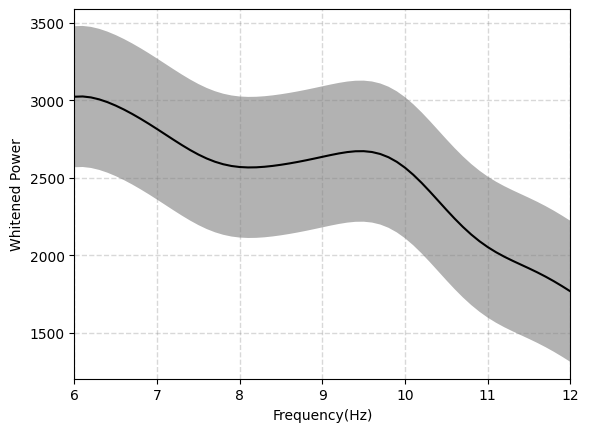

In [ ]:
plt.plot(df_welch[(df_welch['f'] >= 4 ) & (df_welch['f'] <= 12 )]['f'],theta_power_prl_pre,linewidth = 1.5, color = 'black', label = 'LFP power')
plt.fill_between(df_welch[(df_welch['f'] >= 4 ) & (df_welch['f'] <= 12 )]['f'],theta_power_prl_pre-2*error_power,theta_power_prl_pre+2*error_power,color = 'black',alpha = 0.3,edgecolor=None)
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both', which = 'both')
# plt.xscale('log')
plt.xlim(6,12)
# plt.yscale('log')
# plt.ylim([10e2,0.7e5])
plt.ylabel('Whitened Power')
plt.xlabel('Frequency(Hz)')

In [ ]:
f,cxx = signal.coherence(lfp_odorless, resp_odorless, fs = 1000,nperseg = 1000,nfft = 10*1000)
f,t,p = signal.spectrogram(x,fs = srate,window = ('hamming'),nperseg = int(srate/25), noverlap = int(srate/30),nfft = 10*srate)

#RASCUNHOS

In [ ]:
load = Session(ratos['CCM559']['OF_pre']).recordnodes[0].recordings[0]
t_raw= load.continuous[0].timestamps
t = t_raw-t_raw[0]

prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,30]
x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,32]
y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,33]
z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[0:600000,34]
events = load.events

x = np.array(x)
y = np.array(y)
z = np.array(z)
acel = abs(pd.DataFrame(np.sqrt( x**2 + y**2 + z**2  )))

acel = np.array(acel)
acel = np.diff(acel, axis = 0)
acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

parado_bool = np.array(acel  <= 0.001 )
indices_parado = []
for x in range(len(parado_bool)):
    if parado_bool[x:(x+500)].all() == True:
      indices_parado.append(x)



In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
csv = pd.read_csv('/content/drive/MyDrive/CCM559_OpenField_2022-12-16-095045-0000DLC_resnet50_desamparo_aprendido_catheJun4shuffle1_100000_filtered.csv')

In [ ]:
dataframe = pd.DataFrame({'frame': csv['scorer'], 'x': csv['DLC_resnet50_desamparo_aprendido_catheJun4shuffle1_100000.3'], 'y': csv['DLC_resnet50_desamparo_aprendido_catheJun4shuffle1_100000.4'], 'bodypart': 'cabeça' })

In [ ]:
remover = [0,1]
dataframe.drop(remover)


In [ ]:
len(df[(df['animal'] == 'CCM559') & (df['condicao'] == 'OF_pos')]['data_PRL'])

In [ ]:

plt.plot(df[(df['animal'] == 'CCM497') & (df['condicao'] == 'OF_pre')]['data_PRL'])
plt.fill_between(f,mean_power-2*error_power,mean_power+2*error_power,color = 'black',alpha = 0.3,edgecolor=None)
# plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both', which = 'both')
# plt.xscale('log')
plt.xlim([0,50])
# plt.ylim([10e2,0.7e5])
plt.ylabel('Normalized Power')
plt.xlabel('Frequency(Hz)')

In [ ]:
dado = df[(df['animal'] == 'CCM497') & (df['condicao'] == 'OF_pre')]['data_PRL']

In [ ]:
prl_497_pre = df[(df['animal'] == 'CCM497') & (df['condicao'] == 'OF_pre')]['data_PRL']
prl_559_pre = df[(df['animal'] == 'CCM559') & (df['condicao'] == 'OF_pre')]['data_PRL']

PRL_PRE = (prl_497_pre + prl_559_pre)/2 # media

In [ ]:
CCM497_OFPRE = df_final[ (df_final['animal'] =='CCM497') & (df_final['cond'] == 'OF_pre' )]['data_acel']

In [ ]:
plt.plot(df_final[ (df_final['animal'] =='CCM497') & (df_final['cond'] == 'OF_pre' )]['data_acel'])

In [ ]:


session_pre = (Session(str(ratos['CCM497']['OF_pre']))).recordnodes[0].recordings[0]
# session_pos = (Session(str(ratos['CCM497']['OF_pos']))).recordnodes[0].recordings[0]






# data_pre = (pd.DataFrame(session_pre.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))).iloc[:,:32]

#canal com o melhor sinal p representar cada região
# PRL_pre = signal.filtfilt(b, a, data_pre.iloc[:,30]) #selecionando todas as linhas do canal 30
# CG1_pre = signal.filtfilt(b, a, data_pre.iloc[:,9])


In [ ]:
data_PRL = pd.DataFrame(session_pre.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t_pre))).iloc[:,30]
PRL_pre = signal.filtfilt(b, a, data_PRL)


OF_parado = []
for i in indices_parado:
  OF_parado.append(data_PRL[i])

f, p = welch(OF_parado, fs=1000, nperseg=1000, noverlap = (0.5*1000), nfft=10000)
# p = p/np.mean(p)
mean_power = mean_power = np.mean(p)*f
error_power = (np.std(p)*f)

In [ ]:
plt.plot(f,mean_power,linewidth = 1.5, color = 'black', label = 'LFP power')
# plt.fill_between(f,mean_power-2*error_power,mean_power+2*error_power,color = 'black',alpha = 0.3,edgecolor=None)
# plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both', which = 'both')
# plt.xscale('log')
# plt.xlim([0.5,300])
# plt.ylim([10e2,0.7e5])
plt.ylabel('Whitened Power')
plt.xlabel('Frequency(Hz)')

. Specifically, we employed a 1 s moving window with half a window overlap, setting the numerical frequency resolution to 0.1 Hz (by setting the nfft parameter to 10 times the sampling rate).

In [ ]:
plt.plot(f, 10*np.log10(p))
plt.xlim(0,12)
plt.ylim(0,30)

In [ ]:
df = pd.DataFrame({'data_welch': p})
df['freq'] = f
df['cond'] = 'OF_pre'
df['animal'] = 'CCM497'
df['regiao'] = 'PRL'

In [ ]:
df

In [ ]:
plt.plot(f, df['data_welch'])
plt.xlim(0,12)


In [ ]:
frq = df[(df['freq'] >= 4) & (df['freq'] <= 12)]['freq']
pot = df[(df['freq'] >= 4) & (df['freq'] <= 12)]['data_welch']

plt.plot(frq, 10**((10*np.log10(pot))/10))

# plt.xlim(0,50)

In [ ]:
10**((10*np.log10(5))/10)

In [ ]:
def tempo_para_pontos(tempo):
    minutos, segundos = map(int, tempo.split(':'))
    total_segundos = minutos * 60 + segundos
    pontos = total_segundos * 1000
    return pontos

In [ ]:
print(tempo_para_pontos('4:21'))
print(tempo_para_pontos('4:28'))

In [ ]:
plt.plot( media_movel [0:600000] )
plt.xlim(176556,178556)
plt.axvline(x=177556, color='r', linestyle='--')
# plt.axvline(x=268000, color='r', linestyle='--')
plt.axhline(y=0.1, color='r', linestyle='--')

In [ ]:
df = pd.DataFrame({'data_filt': PRL_pre})
df['cond'] = 'OF_pre'
df['animal'] = 'CCM497'
df['regiao'] = 'PRL'

In [ ]:
analytic_signal = hilbert(OF_parado)

# Get the amplitude and phase components
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.angle(analytic_signal)

In [ ]:

# for index,key in enumerate(condicao): # a funcao enumerate retorna o incice e o valor, aqui nesse caso eu vou usar só o valor que é uma key do meu dicionario 'condicao'
#   f, p = welch(condicao[key], fs=1000, nperseg=1000, noverlap = 900)
#   p = p/np.mean(p)

#   df_temp = pd.DataFrame({'freq':f,'pot':p[0]}) #criando um df temporário com as freq e pot
#   df_temp['cond'] = key #adicionando ao df uma coluna com a condicao do exp

#   if index == 0: # aqui estou criando pela primeira vez o df, ele será atualizado no else
#     df_final = df_temp
#   else:
#     df_final = pd.concat([df_final, df_temp], ignore_index=True) #todos os proximos rounds o df temporario vai ser atualizado e concatenado no df final

# df_final

## Como acessar elementos de um DataFrame:

In [ ]:
df_final['pot']

In [ ]:
df_final['pot'].plot()

In [ ]:
df_final.iloc[0:501,1].plot()

In [ ]:
df_final.iloc[0] # iloc acessa indices numericos do df, o primeiro item são as LINHAS, o segundo são as COLUNAS

In [ ]:
df_final.loc[:,'cond']

In [ ]:
df['cond'] = 'PRL_pre' # com essa linha estou criando uma coluna em que a condicao se repete

## Como filtrar um DataFrame:

In [ ]:
(df_final['cond'] == 'PRL_pre').mean() # fazendo a media vc terá a proporcao desse elemento dentro do df

(df_final['cond'] == 'PRL_pre').sum() # ao somar vc conta quantos elementos correspondem a essa condicao

In [ ]:
df_final['cond'] == 'PRL_pre' #criando uma mascara booleana, ela servirá de índice para o seu df, o resultado vai mostrar só as condiçoes que estão dentro desse indice

In [ ]:
df_final[df_final['cond'] == 'PRL_pre'] # assim esta indexando o df com uma mascara booleana, ira resultar apenas nas partes que correspondem a condicao q esta dentro do []

In [ ]:
PSD_PRE = df_final.query(' (12 >= freq >= 4) and (cond == "PRL_pre") ') #esse query vc cria condiçoes que vai querer filtrar o df

In [ ]:
plt.plot(df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pre')]['freq'],df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pre')]['pot'], label = 'theta PRL_pre')
plt.plot(df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pos')]['freq'],df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pos')]['pot'], label = 'theta PRL_pos')
plt.legend()

In [ ]:
df_final.groupby(['cond'], as_index = False)['pot'].agg({'mean_p':np.mean, 'SE':sp.stats.sem})

In [ ]:


for i in range(len(condicao)):
    key, value = list(condicao.items())[i]
    plt.plot(f, 10**(10*np.log10(potencia[i].transpose())/10), label = str(key))
    plt.xlim(0, 20)
plt.title('PSD before and after Screening session')
plt.legend()





  # for i in range(len(condicao)):
  #   for condicao in condicao:
  #     plt.plot(f, 10**(10*np.log10(potencia[i].transpose())/10) , label = condicao)
  #     plt.legend()
  #     plt.xlim(0,20)

In [ ]:
f, p = welch(PRL_pre, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('PRL pré-screening')

In [ ]:
f, p = welch(PRL_pos, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('PRL pos-screening')





In [ ]:
f, p = welch(CG1_pre, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('CG1 pré-screening')


In [ ]:
f, p = welch(CG1_pos, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('CG1 pos-screening')


In [ ]:
pip install statsmodels

before = media_pre
after = media_pos
statistic, p_value = wilcoxon(before, after)
# Print the test statistic and p-value
print("Wilcoxon signed-rank test statistic:", statistic)
print("P-value:", p_value)

> # TETRODO7: CH3

In [ ]:
f, p = welch(lista_filt_pre[2], fs=1000, nperseg=1000, noverlap = 900)
f2, p2 = welch(lista_filt_pos[2], fs=1000, nperseg=1000, noverlap = 900)

sdmn_dpre = sp.stats.sem(p)
sdmn_pos = sp.stats.sem(p2)

figura = plt.figure(figsize=(10,5))
figura.suptitle('PSD, OF pre e pós sessão de screening + 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f, p.transpose())
plt.fill_between(f,p.transpose(),  p.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(f,p.transpose(),  p.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('PSD OF pré-Screening', fontweight ="bold")
plt.xlim(0,20)

figura.add_subplot(122)
plt.plot(f2, p2.transpose())
plt.fill_between(f2,p2.transpose(),  p2.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(f2,p2.transpose(),  p2.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('PSD OF pós-Screening', fontweight ="bold")
plt.xlim(0,20)


In [ ]:
f, p = welch(lista_filt_pre[2], fs=1000, nperseg=1000, noverlap = 900)
f2, p2 = welch(lista_filt_pos[2], fs=1000, nperseg=1000, noverlap = 900)

sdmn_dpre = sp.stats.sem(p)
sdmn_pos = sp.stats.sem(p2)

figura = plt.figure(figsize=(10,5))
figura.suptitle('PSD normalizado, OF pre e pós sessão de screening', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f, 10*np.log10(p.transpose()))
plt.title('PSD OF pré-Screening', fontweight ="bold")
plt.xlim(0,20)
plt.ylim(0,30)
figura.add_subplot(122)
plt.plot(f2, 10*np.log10(p2.transpose()))
plt.title('PSD OF pós-Screening', fontweight ="bold")
plt.xlim(0,20)
plt.ylim(0,30)

In [ ]:
print(len(lista_filt_pre[2]))

In [ ]:
pre = lista_filt_pre[2]
pos = lista_filt_pos[2]

sx = np.concatenate([pre, pos])

f, t, Sxx = spectrogram(sx, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
plt.pcolormesh(t, f, Sxx, cmap='turbo')
plt.ylim(0,30)
# plt.xlim(0,50)
plt.title( 'OF pré e pós sessão de screening ', fontweight ="bold" )
plt.axvline(x=92, color = 'white', linestyle = '--')
plt.xlabel('t(s)')
plt.ylabel('Frequências')
plt.colorbar()

In [ ]:
# FILTRANDO DELTA E THETA
window = signal.windows.hamming(1000)
filt_theta = firwin(300, [4,8], pass_zero='bandpass', window='hamming',  fs=1000)

media_theta_alltrials = (np.sum(lista_CS[2], axis=0))/30
theta = filtfilt(filt_theta, 1, media_theta_alltrials)

theta_pre = theta[0:2000]
theta_pos = theta[2000:4000]


f_pre, p_pre = welch(theta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pre = sp.stats.sem(p_pre)


f_pos, p_pos = welch(theta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pos = sp.stats.sem(p_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('THETA pré e pós screening, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,p_pre.transpose(), linewidth=1, color='k')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() + 4*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() - 4*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta OF pré screening',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,p_pos.transpose(), linewidth=1, color='k')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() + 4*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() - 4*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta OF pós screening', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')


In [ ]:
filt_delta = firwin(300, [0.1,4], pass_zero='bandpass', window='hamming',  fs=1000)

media_delta_alltrials = (np.sum(lista_CS[2], axis=0))/30
delta = filtfilt(filt_delta, 1, media_delta_alltrials)

delta_pre = delta[0:2000]
delta_pos = delta[2000:4000]

fd_pre, pd_pre = welch(delta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpre = sp.stats.sem(pd_pre)

fd_pos, pd_pos = welch(delta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpos = sp.stats.sem(pd_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('DELTA Média dos 30 trials, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,pd_pre.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,pd_pos.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() + 4*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() - 4*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

* fazendo o PSD do trial 29, ele teve um espectrograma interessante

In [ ]:
theta = filtfilt(filt_theta, 1, lista_CS[2][28])

theta_pre = theta[0:2000]
theta_pos = theta[2000:4000]


f_pre, p_pre = welch(theta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pre = sp.stats.sem(p_pre)


f_pos, p_pos = welch(theta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pos = sp.stats.sem(p_pos)


In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('THETA trial 29, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,p_pre.transpose(), linewidth=1, color='k')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() + 4*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() - 4*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta PRE-CS',fontweight ="bold")
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,p_pos.transpose(), linewidth=1, color='k')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() + 4*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() - 4*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta POS-CS', fontweight ="bold")
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')


* estou achando estranho pq o espectrograma não está mostrando esse power todo em 6HZ! ?????????

In [ ]:
filt_delta = firwin(300, [0.1,4], pass_zero='bandpass', window='hamming',  fs=1000)


delta = filtfilt(filt_delta, 1, lista_CS[2][28] )

delta_pre = delta[0:2000]
delta_pos = delta[2000:4000]

fd_pre, pd_pre = welch(delta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpre = sp.stats.sem(pd_pre)

fd_pos, pd_pos = welch(delta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpos = sp.stats.sem(pd_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('DELTA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,pd_pre.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() + 2*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() - 2*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,pd_pos.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() + 2*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() - 2*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('NORMALIZED THETA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,10*np.log10(p_pre.transpose()), linewidth=1, color='k')
plt.fill_between(f_pre,10*np.log10(p_pre.transpose()),  10*np.log10(p_pre.transpose()) + 2*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,10*np.log10(p_pre.transpose()),  10*np.log10(p_pre.transpose()) - 2*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta PRE-CS',fontweight ="bold")
plt.ylim(0,30)
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,10*np.log10(p_pos.transpose()), linewidth=1, color='k')
plt.fill_between(f_pos,10*np.log10(p_pos.transpose()), 10*np.log10(p_pos.transpose())+ 2*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,10*np.log10(p_pos.transpose()), 10*np.log10(p_pos.transpose()) - 2*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta POS-CS', fontweight ="bold")
plt.xlim(2,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('NORMALIZED DELTA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,10*np.log10(pd_pre.transpose()), linewidth=1, color='k')
plt.fill_between(fd_pre,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) + 2*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) - 2*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,10*np.log10(pd_pre.transpose()), linewidth=1, color='k')
plt.fill_between(fd_pos,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) + 2*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) - 2*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

* AO NORMALIZAR, O DELTA PARECE ESTAR MUITO PARECIDO, NÃO ENTENDI ISSO TB!!!





> # US CUT

In [ ]:
lista_sinais = []
for i in range(32):
  lista_sinais.append(data[:,[i]])


#lista do valor máximo de cada canal

lista_mean_abs = []
for i in range(32):
  lista_mean_abs.append(np.max(np.abs(data[:,[i]])))

#definindo o threshold
threshold = (np.max(lista_mean_abs))/5


In [ ]:
shockTimestamp = np.zeros(914700)

idx_shock = np.array(lista_sinais[2][:])>=threshold
shockTimestamp[idx_shock[:,0]] = 1

plt.figure(figsize=(10,5))
plt.plot(shockTimestamp)
# plt.xlim(20000,22000)


In [ ]:
intervalos=[]
choque=0
registrando = 0
for i in range(0,len(shockTimestamp)):
  if (shockTimestamp[i]==0) and (shockTimestamp[i-1]==1):
    if(i+10000) < 913700:
      msmbarra = False
      for j in range(i,i+10000):
        if(shockTimestamp[j]==1):
          msmbarra=True
          break
      if msmbarra == False:
        choque=choque+1
        para_registrar=[]
        for k in range(i,i+4000):
          para_registrar.append(lista_sinais[2][k])
        intervalos.append(para_registrar)
    else:
      msmbarra = False
      for j in range(i,i+5000):
        if(shockTimestamp[j]==1):
          msmbarra=True
          break
      if msmbarra == False:
          choque=choque+1
          #print('queijo')
          para_registrar=[]
          for k in range(i,i+4000):
            #print(k)
            para_registrar.append(lista_sinais[2][k])
          intervalos.append(para_registrar)

In [ ]:
intervalos